In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding
from imap.model.embeddings.gaussian_positional_embedding import GaussianPositionalEmbedding
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling
from imap.utils.utils import *

from imap.utils.image_renderer import ImageRenderer

In [3]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.update_layout(height=1280,width=960)
    fig.show()
    
    



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def make_matrix_44_from_34(matrix):
    result = np.zeros((matrix.shape[0], 4, 4))
    result[:, 3, 3] = 1
    result[:, :3, :] = matrix
    return result

# Track a few images

### Train on 1 image

In [4]:

dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(0,573,20)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [5]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEmbedding',
                                        encoding_dimension=93,
                                        sigma=25,
                                        use_only_sin=False,
                                        use_bias=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding, GaussianPositionalEmbedding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

In [8]:
model.cuda()
model.train()

image_active_sampler = ImageActiveSampling(image_width=640, image_height=480, points_per_frame=200)
trainer = ModelTrainer(model.parameters(), image_active_sampler, lr=0.005)

trainer.train_model(model, dataset_loader, camera, 300, is_image_active_sampling=True)

  0%|          | 0/300 [00:00<?, ?it/s]

loss 2.1323397159576416
loss 1.5447039604187012
loss 1.8533484935760498
loss 1.7453689575195312
loss 1.4934654235839844
loss 1.471779704093933
loss 1.3713488578796387
loss 1.3686702251434326
loss 1.3197332620620728
loss 1.3771462440490723
loss 1.1215226650238037
loss 1.1592254638671875
loss 1.1745631694793701
loss 1.2574963569641113
loss 1.2311092615127563
loss 1.0722415447235107
loss 1.0122939348220825
loss 0.935886561870575
loss 0.9108917117118835
loss 1.0542808771133423
loss 0.9333573579788208
loss 0.9704789519309998
loss 1.0050632953643799
loss 0.8974746465682983
loss 0.9837766289710999
loss 0.8893428444862366
loss 0.9436441659927368
loss 0.96256023645401
loss 0.9787220358848572
loss 0.8506268262863159
loss 0.989247739315033
loss 0.9870736598968506
loss 0.8725224137306213
loss 0.8039336800575256
loss 0.8320426940917969
loss 0.765945315361023
loss 0.8370359539985657
loss 0.9156028032302856
loss 0.8297367095947266
loss 0.8581631183624268
loss 0.8087669014930725
loss 0.785110771656036

In [12]:
# model.eval()
# color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = render_images(model, camera, dataset_loader)
camera.image_height = 480
camera.image_width = 640
image_renderer = ImageRenderer(camera)
model.eval()
color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = [], [], [], []
i=10
for _, _, position in dataset_loader:

    position_to_render = torch.from_numpy(camera.process_positions(position)).to('cuda')
    
    color_coarse_image, depth_coarse_image, color_fine_image, depth_fine_image = image_renderer.render_output(model, position_to_render)
    color_coarse_images.append(color_coarse_image)
    depth_coarse_images.append(depth_coarse_image)
    color_fine_images.append(color_fine_image)
    depth_fine_images.append(depth_fine_image)
    i -=1
    if i <0:
        break

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

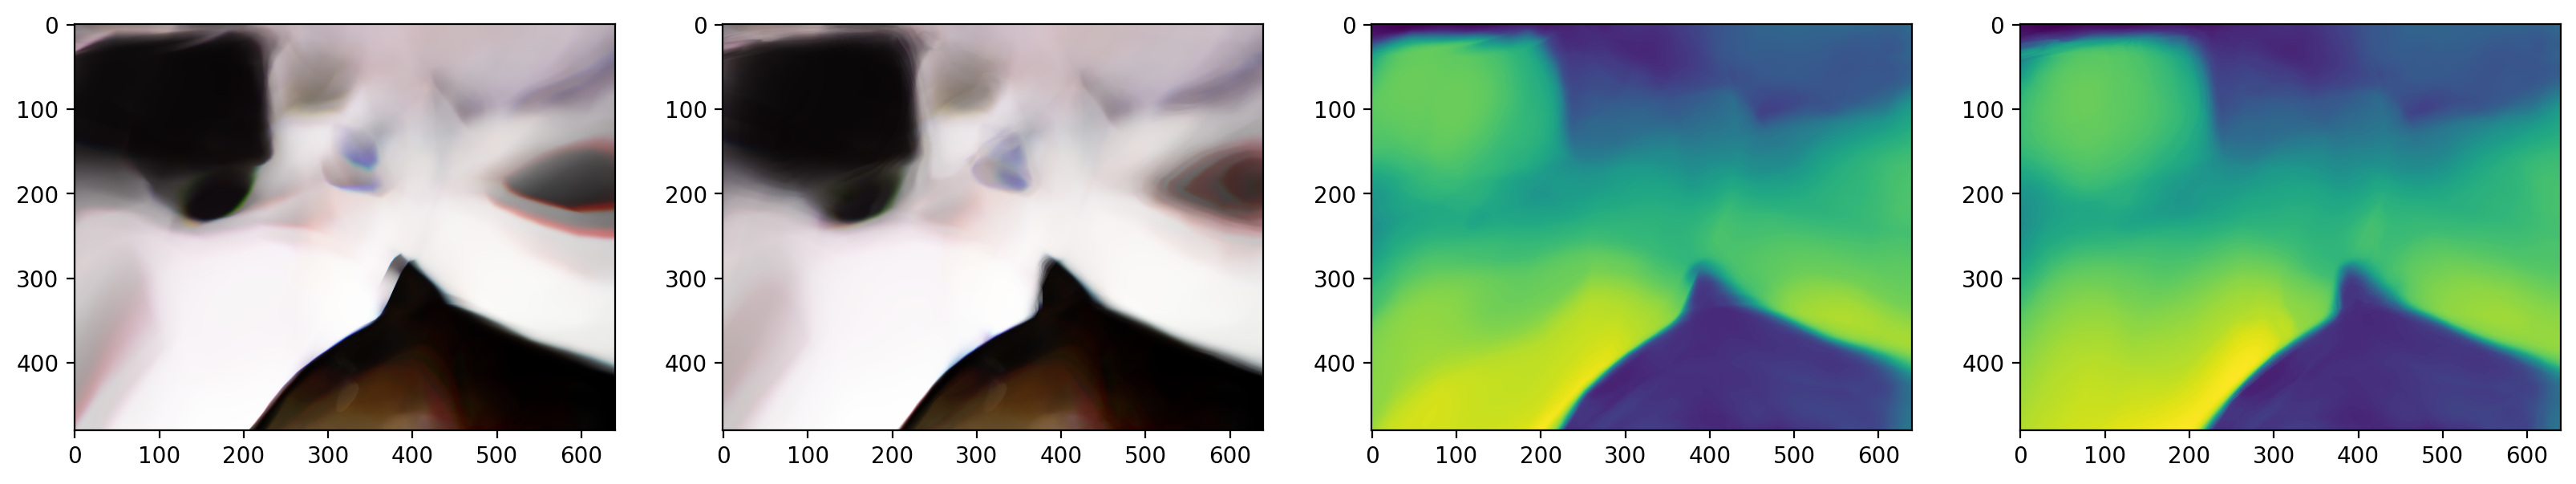

In [13]:
indx = 0
figure = plt.figure(dpi=200, figsize=(20,18))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(color_coarse_images[indx], cv2.COLOR_RGB2BGR))


plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(color_fine_images[indx], cv2.COLOR_RGB2BGR))

plt.subplot(1,4,3)
plt.imshow(1. /depth_coarse_images[indx])


plt.subplot(1,4,4)
plt.imshow(1. /depth_fine_images[indx])

### Tracking

In [14]:
dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(573)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, tracking_dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [15]:
poses = trainer.localization(model, tracking_dataset_loader, camera)

  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7458072304725647
loss 0.890569269657135
loss 0.6033643484115601
loss 0.8179224729537964
loss 0.6716876029968262
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7119005918502808
loss 0.7967840433120728
loss 0.9345775246620178
loss 0.799859881401062
loss 0.7066600918769836
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7695576548576355
loss 0.8766859173774719
loss 0.8382376432418823
loss 0.7950466871261597
loss 0.7598206996917725
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9412640333175659
loss 0.9033200144767761
loss 0.8035041093826294
loss 0.7052425742149353
loss 0.8808308243751526
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7867765426635742
loss 0.726385772228241
loss 0.936583936214447
loss 0.7094359993934631
loss 0.696073055267334
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8466922044754028
loss 1.1923900842666626
loss 0.7706817388534546
loss 0.7311616539955139
loss 0.7550106644630432
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.903436541557312
loss 0.8693560361862183
loss 0.8555624485015869
loss 0.7620512247085571
loss 0.7789552807807922
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8310956358909607
loss 0.8981812596321106
loss 1.106114387512207
loss 0.7899748086929321
loss 0.7251203656196594
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9364222288131714
loss 1.214086890220642
loss 0.7390432357788086
loss 0.8353419303894043
loss 0.9030383229255676
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9400849938392639
loss 0.8321095108985901
loss 0.832642138004303
loss 0.9988937973976135
loss 0.8488284349441528
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8964024186134338
loss 0.9201552271842957
loss 0.8757773637771606
loss 0.813605010509491
loss 0.9153527021408081
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7797977924346924
loss 1.2732527256011963
loss 0.743573009967804
loss 0.7907845973968506
loss 0.8180174231529236
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.854401707649231
loss 0.6869087815284729
loss 0.7612863779067993
loss 0.8146918416023254
loss 0.6686567068099976
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0391017198562622
loss 0.9602826237678528
loss 0.8706682920455933
loss 0.9873450994491577
loss 0.8112674355506897
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7284333109855652
loss 0.8118431568145752
loss 0.6708717346191406
loss 0.7440200448036194
loss 0.8133891224861145
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8226940035820007
loss 0.795836329460144
loss 0.6938460469245911
loss 0.8099188804626465
loss 0.8020646572113037
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9184510707855225
loss 0.9464066624641418
loss 1.0029579401016235
loss 0.7501110434532166
loss 0.7821241617202759
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1459234952926636
loss 0.7851424813270569
loss 0.8373355865478516
loss 0.7582727074623108
loss 0.9310603141784668
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1977481842041016
loss 0.6909319758415222
loss 0.7544806003570557
loss 0.7573597431182861
loss 0.9815243482589722
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9958516955375671
loss 0.7832056879997253
loss 0.8305082321166992
loss 0.8140319585800171
loss 0.6909434199333191
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1157654523849487
loss 0.9125095009803772
loss 0.6644963026046753
loss 0.8048949837684631
loss 0.8564758896827698
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2719833850860596
loss 0.742205023765564
loss 0.806176483631134
loss 0.9226395487785339
loss 0.904016375541687
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0872381925582886
loss 0.9145171642303467
loss 0.8047459125518799
loss 0.9191732406616211
loss 0.9209612011909485
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0279607772827148
loss 0.889553964138031
loss 0.946539580821991
loss 0.9798843264579773
loss 0.8953529000282288
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2141449451446533
loss 1.2793664932250977
loss 0.9831201434135437
loss 0.9433062672615051
loss 0.9102481007575989
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.09274423122406
loss 1.0761058330535889
loss 0.9350904822349548
loss 0.9871369004249573
loss 0.9366593956947327
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2133249044418335
loss 1.1088764667510986
loss 0.9657779335975647
loss 1.0037767887115479
loss 0.9986864924430847
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0125294923782349
loss 0.9941350221633911
loss 0.9355202913284302
loss 0.9072737097740173
loss 0.9098600745201111
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0609906911849976
loss 0.9778398871421814
loss 0.9163306355476379
loss 1.0145585536956787
loss 0.9878780245780945
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1292537450790405
loss 0.9820446372032166
loss 0.9743991494178772
loss 0.9765084385871887
loss 0.9746332168579102
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9939877390861511
loss 0.8475739359855652
loss 0.8954418897628784
loss 0.919762372970581
loss 0.8487105965614319
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9620741605758667
loss 0.8284112215042114
loss 0.9051092267036438
loss 0.8506574630737305
loss 0.816253125667572
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0212076902389526
loss 0.9475440979003906
loss 0.7957205772399902
loss 0.8495263457298279
loss 0.9044802784919739
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8997107744216919
loss 0.9289655089378357
loss 0.8371032476425171
loss 0.9677731394767761
loss 0.8738027215003967
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.015872597694397
loss 0.8757016062736511
loss 0.852135956287384
loss 0.8486680388450623
loss 0.8775208592414856
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9335763454437256
loss 0.823786735534668
loss 0.8352346420288086
loss 0.9040617346763611
loss 0.823110044002533
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.996094286441803
loss 0.8499824404716492
loss 0.8206172585487366
loss 0.8205221891403198
loss 0.8704167008399963
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9284398555755615
loss 0.8724066615104675
loss 0.8258349895477295
loss 0.8165287375450134
loss 0.8122999668121338
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9904638528823853
loss 0.8385015726089478
loss 0.8238691687583923
loss 0.8238109946250916
loss 0.8616312742233276
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1067591905593872
loss 0.8306294083595276
loss 0.8530145883560181
loss 0.7683175206184387
loss 0.7710897922515869
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9749135971069336
loss 0.7981005907058716
loss 0.8527868986129761
loss 0.7952181696891785
loss 0.6918063163757324
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9516387581825256
loss 0.8095220923423767
loss 0.7582405209541321
loss 0.6475936770439148
loss 0.7514194846153259
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8393711447715759
loss 0.8298699855804443
loss 0.7434716820716858
loss 0.7288434505462646
loss 0.7220768332481384
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8102858066558838
loss 0.8795951008796692
loss 0.7841885089874268
loss 0.6894376873970032
loss 0.7690811157226562
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7491861581802368
loss 0.8012804985046387
loss 0.7114005088806152
loss 0.7140078544616699
loss 0.8032441735267639
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.760294497013092
loss 0.8267776370048523
loss 0.778930127620697
loss 0.767975389957428
loss 0.7394120693206787
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8051873445510864
loss 0.785540759563446
loss 0.725949227809906
loss 0.7826460003852844
loss 0.6799566745758057
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8146685361862183
loss 0.7932058572769165
loss 0.7021172046661377
loss 0.8378950357437134
loss 0.6969446539878845
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.608436644077301
loss 0.7990896701812744
loss 0.780597448348999
loss 0.7146177291870117
loss 0.6901438236236572
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7211886644363403
loss 0.7717044949531555
loss 0.733872652053833
loss 0.8433089256286621
loss 0.7980177402496338
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7779470086097717
loss 0.7754082083702087
loss 0.8070547580718994
loss 0.7163246273994446
loss 0.7726559042930603
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7827776074409485
loss 0.8647703528404236
loss 0.7483090758323669
loss 0.843553900718689
loss 0.7414186000823975
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8213435411453247
loss 0.8294179439544678
loss 0.8722676038742065
loss 0.826797604560852
loss 0.8068591952323914
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8965107798576355
loss 0.8229897618293762
loss 0.7818249464035034
loss 0.8050976395606995
loss 0.8149815201759338
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7563180923461914
loss 0.7665669918060303
loss 0.7320774793624878
loss 0.7517139315605164
loss 0.768045961856842
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.746220052242279
loss 0.8520573377609253
loss 0.7097479701042175
loss 0.8153009414672852
loss 0.7371178269386292
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6977540254592896
loss 0.8075791597366333
loss 0.6895257234573364
loss 0.8386253118515015
loss 0.6898667812347412
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6921989321708679
loss 0.8018010258674622
loss 0.7641283869743347
loss 0.7642682194709778
loss 0.8063539862632751
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8326277732849121
loss 0.9102252125740051
loss 0.7910316586494446
loss 0.7479597330093384
loss 0.7718000411987305
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7862862944602966
loss 0.7795095443725586
loss 0.8398146033287048
loss 0.7923879623413086
loss 0.6716729402542114
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9815974831581116
loss 0.805852472782135
loss 0.7675507068634033
loss 0.7078353762626648
loss 0.9420022964477539
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8269324898719788
loss 0.7373189926147461
loss 0.7922537922859192
loss 0.7572754621505737
loss 0.8301214575767517
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8007575273513794
loss 0.8269703388214111
loss 0.7575997710227966
loss 0.9624146819114685
loss 0.8272087574005127
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8323020935058594
loss 0.9538378119468689
loss 0.8523486256599426
loss 0.9434292316436768
loss 0.86177659034729
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8231934309005737
loss 0.8871232271194458
loss 0.866787850856781
loss 0.8371991515159607
loss 1.058260202407837
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8493381142616272
loss 0.873329758644104
loss 0.8052952885627747
loss 0.872273862361908
loss 0.922920823097229
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9920042753219604
loss 0.9428104758262634
loss 0.7916433811187744
loss 0.9078832864761353
loss 0.7493036985397339
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9557511806488037
loss 0.8604028820991516
loss 0.7433180809020996
loss 0.8268656730651855
loss 0.7670826315879822
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8376386761665344
loss 0.8820928931236267
loss 0.7417916655540466
loss 0.8293179273605347
loss 0.8150425553321838
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8176450729370117
loss 0.911871612071991
loss 0.8455807566642761
loss 0.8081663250923157
loss 0.9271317720413208
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0172736644744873
loss 0.8327032327651978
loss 0.8185138702392578
loss 0.802297830581665
loss 0.9258291125297546
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.902350127696991
loss 0.8430172801017761
loss 0.824543297290802
loss 0.9732192158699036
loss 0.8368282914161682
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9571446776390076
loss 0.902367889881134
loss 0.8285547494888306
loss 0.8119035363197327
loss 0.9114348292350769
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8339381814002991
loss 0.7737707495689392
loss 0.8360598683357239
loss 0.8732986450195312
loss 0.8316453099250793
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8129899501800537
loss 0.9258061647415161
loss 0.8707911372184753
loss 1.0820553302764893
loss 0.9478223919868469
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8078747391700745
loss 0.9843489527702332
loss 0.9470886588096619
loss 0.9567912220954895
loss 0.9561430215835571
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9092057347297668
loss 0.8804917931556702
loss 0.8822654485702515
loss 0.8428152203559875
loss 0.9477570652961731
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8606349229812622
loss 0.818832516670227
loss 0.9175329208374023
loss 0.807230532169342
loss 0.8595478534698486
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8838198781013489
loss 0.8220950365066528
loss 0.8369356393814087
loss 0.9192997813224792
loss 0.8695147037506104
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9114130735397339
loss 0.7535027265548706
loss 0.848120391368866
loss 0.8217468857765198
loss 0.8606892228126526
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0883443355560303
loss 0.9942674040794373
loss 0.8082636594772339
loss 0.9457646608352661
loss 0.8089880347251892
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8368021845817566
loss 1.0703452825546265
loss 0.9061781764030457
loss 1.1804180145263672
loss 1.0630377531051636
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1676127910614014
loss 1.0003612041473389
loss 0.870318591594696
loss 0.9871295094490051
loss 0.9310247302055359
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8519018292427063
loss 0.938129723072052
loss 0.9132617115974426
loss 0.8479124903678894
loss 0.8444650173187256
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9673103094100952
loss 0.8791056871414185
loss 0.9790748357772827
loss 1.0277916193008423
loss 0.9545112252235413
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0410650968551636
loss 0.9599980711936951
loss 0.8813201785087585
loss 0.8914315104484558
loss 0.868467390537262
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9817734956741333
loss 0.9066230058670044
loss 0.926371157169342
loss 0.992104709148407
loss 1.0034009218215942
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0471177101135254
loss 1.010759711265564
loss 0.9723426103591919
loss 0.9841164946556091
loss 0.9911199808120728
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9916020631790161
loss 0.952382504940033
loss 0.985985517501831
loss 0.8958351016044617
loss 1.0896469354629517
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3189456462860107
loss 1.0569863319396973
loss 0.8900926113128662
loss 1.0779095888137817
loss 1.1081217527389526
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0556175708770752
loss 1.0274711847305298
loss 1.065428376197815
loss 1.0482544898986816
loss 0.9287878274917603
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9661922454833984
loss 1.09944748878479
loss 1.011048436164856
loss 1.0314910411834717
loss 1.0048383474349976
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0757638216018677
loss 0.9053823947906494
loss 1.029404640197754
loss 0.9554447531700134
loss 0.9719396829605103
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0763474702835083
loss 1.0150737762451172
loss 0.9204870462417603
loss 0.9813385009765625
loss 0.9401457905769348
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1692066192626953
loss 0.9194266200065613
loss 0.9582850933074951
loss 0.8916471600532532
loss 0.8273901343345642
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9535273313522339
loss 1.0288070440292358
loss 0.9997967481613159
loss 1.1573246717453003
loss 0.9715432524681091
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.155742883682251
loss 1.2122626304626465
loss 0.9915014505386353
loss 0.9025865197181702
loss 1.0323054790496826
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2393414974212646
loss 1.0283377170562744
loss 1.0790627002716064
loss 1.055653691291809
loss 1.1539232730865479
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.109559416770935
loss 0.9088197350502014
loss 1.1664940118789673
loss 0.9852828979492188
loss 1.0493296384811401
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0159211158752441
loss 1.2314131259918213
loss 0.9541640877723694
loss 0.9919270873069763
loss 1.0908700227737427
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0706406831741333
loss 1.1725794076919556
loss 0.9179508686065674
loss 1.1789814233779907
loss 1.0138084888458252
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.004399299621582
loss 1.0813485383987427
loss 0.9418879747390747
loss 0.97284996509552
loss 0.9253793358802795
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1014645099639893
loss 1.0179144144058228
loss 1.0219430923461914
loss 0.9687239527702332
loss 0.9091642498970032
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.012974500656128
loss 1.1315743923187256
loss 1.1313719749450684
loss 1.1188230514526367
loss 1.1287939548492432
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1326385736465454
loss 0.9862955212593079
loss 1.0238317251205444
loss 1.0606733560562134
loss 1.2432165145874023
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0085240602493286
loss 1.073114275932312
loss 1.043370246887207
loss 1.020174264907837
loss 1.1234781742095947
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0433286428451538
loss 1.1289808750152588
loss 1.0136297941207886
loss 1.173140048980713
loss 1.0441498756408691
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3445391654968262
loss 0.9800782799720764
loss 1.246680736541748
loss 1.1146537065505981
loss 1.0335874557495117
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2561522722244263
loss 1.2516169548034668
loss 1.1115587949752808
loss 1.170706033706665
loss 1.234887719154358
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2618671655654907
loss 1.2399133443832397
loss 1.1976068019866943
loss 1.0453943014144897
loss 1.2279714345932007
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2397979497909546
loss 1.1158376932144165
loss 1.1164299249649048
loss 1.1841214895248413
loss 1.2691773176193237
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.257826566696167
loss 1.1738883256912231
loss 1.295847773551941
loss 1.1392091512680054
loss 1.0522563457489014
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3615471124649048
loss 1.2097069025039673
loss 1.0928051471710205
loss 1.277457594871521
loss 1.1214454174041748
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0836541652679443
loss 1.1316368579864502
loss 1.2706838846206665
loss 1.175635814666748
loss 1.1741199493408203
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2865984439849854
loss 1.2206945419311523
loss 1.2547647953033447
loss 1.245001196861267
loss 1.3526512384414673
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0876734256744385
loss 1.232837438583374
loss 0.9549347758293152
loss 1.0695637464523315
loss 1.0511257648468018
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1563187837600708
loss 1.2111753225326538
loss 0.9835633635520935
loss 1.081231713294983
loss 1.0110900402069092
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0074326992034912
loss 1.0275877714157104
loss 1.0054728984832764
loss 1.1181741952896118
loss 1.03632652759552
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.069453477859497
loss 1.1812326908111572
loss 1.0694860219955444
loss 1.1792536973953247
loss 1.1100497245788574
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1397947072982788
loss 1.1052404642105103
loss 1.0229978561401367
loss 1.0013408660888672
loss 0.9924525022506714
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0726628303527832
loss 1.0531762838363647
loss 1.1652487516403198
loss 1.0136089324951172
loss 1.093751072883606
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0912243127822876
loss 1.0037373304367065
loss 1.0126491785049438
loss 0.9603233337402344
loss 0.9583210349082947
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.038246989250183
loss 0.9937475919723511
loss 1.099429726600647
loss 1.020488977432251
loss 0.9758973717689514
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0537235736846924
loss 1.0559747219085693
loss 0.892645537853241
loss 1.0645527839660645
loss 1.0531816482543945
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9643078446388245
loss 0.9732791185379028
loss 1.0990262031555176
loss 1.0321015119552612
loss 1.008665680885315
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2160799503326416
loss 1.136976957321167
loss 1.126364827156067
loss 1.0996583700180054
loss 1.183111310005188
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4347431659698486
loss 1.0898425579071045
loss 1.066847801208496
loss 1.152597188949585
loss 0.962755560874939
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.181026577949524
loss 1.0706452131271362
loss 1.1218324899673462
loss 1.2334142923355103
loss 1.075911521911621
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0782790184020996
loss 1.294534683227539
loss 1.2695645093917847
loss 1.2446759939193726
loss 1.159312129020691
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1237406730651855
loss 1.166669249534607
loss 1.0962599515914917
loss 1.2186808586120605
loss 1.2050721645355225
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2094680070877075
loss 1.2081148624420166
loss 1.0421943664550781
loss 1.1544502973556519
loss 1.0731518268585205
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.086704969406128
loss 1.2315127849578857
loss 1.0099551677703857
loss 1.1277412176132202
loss 1.1220422983169556
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1496174335479736
loss 1.0097413063049316
loss 1.0194443464279175
loss 1.0639348030090332
loss 1.1019388437271118
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2994407415390015
loss 1.1149853467941284
loss 1.170780062675476
loss 1.0798381567001343
loss 1.0611273050308228
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1007424592971802
loss 1.0256859064102173
loss 1.2248783111572266
loss 1.0905256271362305
loss 1.0563241243362427
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1865971088409424
loss 1.1117819547653198
loss 1.0334546566009521
loss 0.9654719233512878
loss 0.94651198387146
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.157196044921875
loss 1.033237099647522
loss 0.9186468124389648
loss 0.9707906246185303
loss 1.068203330039978
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1513251066207886
loss 0.9674800634384155
loss 1.00113046169281
loss 0.9860798716545105
loss 0.9721137285232544
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1213667392730713
loss 1.0730422735214233
loss 0.9025147557258606
loss 0.908976137638092
loss 0.961068868637085
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9594846963882446
loss 0.7915300726890564
loss 0.9822723269462585
loss 0.9716699719429016
loss 0.9729045629501343
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9362502098083496
loss 0.774595320224762
loss 0.8108639121055603
loss 0.8421710729598999
loss 0.8295338749885559
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3354030847549438
loss 1.0498487949371338
loss 0.9276970624923706
loss 0.7971037030220032
loss 0.8819379806518555
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2584128379821777
loss 0.9272796511650085
loss 0.8876250982284546
loss 0.9567474126815796
loss 0.8955654501914978
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.124879002571106
loss 1.0316425561904907
loss 1.050438642501831
loss 1.0881626605987549
loss 0.9163617491722107
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0692609548568726
loss 0.8829801082611084
loss 0.9978870153427124
loss 1.0266447067260742
loss 0.8786140084266663
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9855890274047852
loss 1.1056900024414062
loss 0.832310140132904
loss 1.1422066688537598
loss 0.8706434369087219
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0533217191696167
loss 0.8388469219207764
loss 0.978316605091095
loss 0.986216127872467
loss 1.019689917564392
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2377368211746216
loss 1.007267713546753
loss 1.0449228286743164
loss 1.1027843952178955
loss 1.054946780204773
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3121740818023682
loss 1.1153877973556519
loss 1.0997344255447388
loss 0.8832206726074219
loss 0.9368653893470764
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4618988037109375
loss 0.9449076652526855
loss 1.0351723432540894
loss 0.9896707534790039
loss 0.8871967196464539
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.310255765914917
loss 1.0002115964889526
loss 0.8759943842887878
loss 1.0779602527618408
loss 0.9139251708984375
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4094274044036865
loss 0.9761094450950623
loss 1.1020252704620361
loss 1.1164823770523071
loss 1.1175271272659302
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1593847274780273
loss 1.3047399520874023
loss 1.17501962184906
loss 0.9762219190597534
loss 1.15447998046875
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.893992006778717
loss 1.0572309494018555
loss 0.9801483154296875
loss 0.8873165845870972
loss 1.184267282485962
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2966488599777222
loss 1.1002753973007202
loss 1.1473753452301025
loss 1.3447985649108887
loss 1.2271904945373535
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.005233645439148
loss 0.958320140838623
loss 1.0426418781280518
loss 0.9530057907104492
loss 1.1669529676437378
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3425320386886597
loss 0.8866191506385803
loss 0.9387609362602234
loss 0.9611042737960815
loss 0.8949711322784424
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0606443881988525
loss 0.9700855612754822
loss 0.9669590592384338
loss 1.1419625282287598
loss 0.8599715828895569
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.177345037460327
loss 1.0019993782043457
loss 0.7941744923591614
loss 0.9260997772216797
loss 0.9722593426704407
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5271532535552979
loss 0.7704015970230103
loss 0.8993218541145325
loss 1.036133885383606
loss 0.9275884628295898
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1640117168426514
loss 0.8710787296295166
loss 0.8590993285179138
loss 0.9152128100395203
loss 0.7152363657951355
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9942886233329773
loss 0.8604752421379089
loss 0.81829833984375
loss 0.8317710757255554
loss 0.7662082314491272
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7835939526557922
loss 0.733202338218689
loss 0.8246488571166992
loss 0.8644570708274841
loss 0.8221845626831055
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1493884325027466
loss 0.9993917346000671
loss 1.0403329133987427
loss 1.1514766216278076
loss 0.9955644011497498
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0262380838394165
loss 0.888892412185669
loss 0.8114410042762756
loss 0.93269282579422
loss 0.9422030448913574
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1680363416671753
loss 0.8859717845916748
loss 0.9929850697517395
loss 1.0267530679702759
loss 0.8964105248451233
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6677100658416748
loss 1.0728813409805298
loss 1.0631555318832397
loss 0.9465101361274719
loss 1.1813713312149048
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7608169317245483
loss 1.0476694107055664
loss 0.8850643038749695
loss 0.8920623064041138
loss 0.9907243847846985
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7526394128799438
loss 1.3278522491455078
loss 1.3249728679656982
loss 1.2731341123580933
loss 1.1315354108810425
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.136040210723877
loss 1.0772418975830078
loss 1.154222846031189
loss 1.1812357902526855
loss 1.2102892398834229
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1527878046035767
loss 1.173087239265442
loss 1.0642762184143066
loss 0.9049773812294006
loss 0.9971129894256592
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9867375493049622
loss 1.0769952535629272
loss 0.952085554599762
loss 0.7964900135993958
loss 0.9028788805007935
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9378722310066223
loss 0.9657029509544373
loss 0.8783341646194458
loss 0.8298842906951904
loss 0.85550856590271
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9580899477005005
loss 0.9363942742347717
loss 0.9293452501296997
loss 0.8638622164726257
loss 0.8673174381256104
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9627101421356201
loss 0.9651758074760437
loss 0.9486806988716125
loss 0.9301897883415222
loss 0.859304666519165
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8987776041030884
loss 0.9261034727096558
loss 0.8895379304885864
loss 0.8519859910011292
loss 0.9027890563011169
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0044751167297363
loss 0.9049433469772339
loss 0.8394494652748108
loss 0.855279803276062
loss 0.9655912518501282
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9342873096466064
loss 1.1336184740066528
loss 0.8994011282920837
loss 0.8403620719909668
loss 0.7685747146606445
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0121530294418335
loss 0.8778093457221985
loss 0.8497030735015869
loss 0.8400071263313293
loss 0.8788020014762878
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9723455309867859
loss 0.8645175695419312
loss 0.7113329768180847
loss 0.7686299085617065
loss 0.7463098764419556
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8676615953445435
loss 0.8726592063903809
loss 0.7836900353431702
loss 0.8129069805145264
loss 0.7240522503852844
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7756029963493347
loss 0.7420485615730286
loss 0.7189059257507324
loss 0.7761794924736023
loss 0.7183834910392761
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.937169075012207
loss 0.7274766564369202
loss 0.7401639223098755
loss 0.8150930404663086
loss 0.7234881520271301
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0337544679641724
loss 0.9066911935806274
loss 0.8591678142547607
loss 0.7571700215339661
loss 0.6470056772232056
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9753451943397522
loss 0.7001479268074036
loss 0.7853615880012512
loss 0.7453723549842834
loss 0.8584471940994263
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8347311019897461
loss 0.7277073264122009
loss 0.8009649515151978
loss 0.8403571844100952
loss 0.7594526410102844
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8409159779548645
loss 0.7733147740364075
loss 0.7529270648956299
loss 0.8507939577102661
loss 0.9877373576164246
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6950932741165161
loss 0.7953980565071106
loss 0.7490801811218262
loss 0.8314730525016785
loss 0.7247931361198425
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8903945684432983
loss 0.7982016801834106
loss 0.7774362564086914
loss 0.8275474309921265
loss 0.8465720415115356
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0308821201324463
loss 0.8436976671218872
loss 0.7972965836524963
loss 0.7389608025550842
loss 0.7706377506256104
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9747776389122009
loss 0.8645544052124023
loss 1.011589765548706
loss 0.9497068524360657
loss 0.9267047643661499
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8314130306243896
loss 1.140718698501587
loss 1.0107859373092651
loss 0.7993925213813782
loss 0.8821182250976562
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.868615984916687
loss 0.9388924837112427
loss 1.0818859338760376
loss 0.8791340589523315
loss 0.8324662446975708
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0378444194793701
loss 1.0837633609771729
loss 0.8955836296081543
loss 0.9107034802436829
loss 0.830295979976654
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0696264505386353
loss 0.8782480359077454
loss 0.9205734133720398
loss 0.8957545757293701
loss 0.8720226883888245
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.928272545337677
loss 0.7726683020591736
loss 1.006563425064087
loss 0.8449560403823853
loss 0.875051736831665
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.976297914981842
loss 0.8942323327064514
loss 0.9909985065460205
loss 0.8402844071388245
loss 0.7556840181350708
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9658045768737793
loss 0.8552647829055786
loss 0.9929900765419006
loss 0.939850389957428
loss 0.8876833915710449
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7910134196281433
loss 0.9899812340736389
loss 0.7892650961875916
loss 0.7700524926185608
loss 0.8797041177749634
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0065652132034302
loss 0.9821475148200989
loss 0.8081277012825012
loss 0.959771990776062
loss 0.8202435970306396
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7739923000335693
loss 0.7566596865653992
loss 0.8561571836471558
loss 0.7823445200920105
loss 0.8681485652923584
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8778907656669617
loss 0.9908874034881592
loss 0.8673242926597595
loss 0.8536887764930725
loss 0.8067159652709961
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8655648827552795
loss 0.8661273121833801
loss 0.8366841077804565
loss 0.9033586978912354
loss 0.904708206653595
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8408626914024353
loss 0.9095235466957092
loss 0.8537778854370117
loss 0.8675224184989929
loss 0.8697666525840759
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9777383208274841
loss 0.9625466465950012
loss 0.8449708223342896
loss 0.8939356207847595
loss 0.9239186644554138
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8611407279968262
loss 0.8771553635597229
loss 0.8719445466995239
loss 0.8437725901603699
loss 0.82075434923172
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8374378681182861
loss 0.9065725803375244
loss 1.0143156051635742
loss 0.8584145903587341
loss 0.8475378751754761
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0151034593582153
loss 0.8446743488311768
loss 0.8644018173217773
loss 0.8374950289726257
loss 0.8548924326896667
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0801070928573608
loss 0.8585739135742188
loss 0.7665481567382812
loss 0.8486510515213013
loss 0.7582122683525085
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9510272741317749
loss 1.0244066715240479
loss 0.7971072196960449
loss 0.8150030970573425
loss 0.9318091869354248
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.731545090675354
loss 0.8381813764572144
loss 0.8284296989440918
loss 0.7774868011474609
loss 0.8685389757156372
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9041334986686707
loss 0.9723772406578064
loss 0.9792071580886841
loss 0.9989320039749146
loss 0.8722478151321411
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9737688899040222
loss 0.8517412543296814
loss 0.902062177658081
loss 0.9030433297157288
loss 0.9736334085464478
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8975228071212769
loss 0.9005768895149231
loss 0.7893865704536438
loss 0.8170124888420105
loss 0.9275628924369812
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0128607749938965
loss 0.9885892868041992
loss 0.9808279275894165
loss 0.8925507664680481
loss 0.9150773882865906
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.118462324142456
loss 0.9623768329620361
loss 0.9925397038459778
loss 0.8895648121833801
loss 0.896625816822052
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9016979932785034
loss 0.910650908946991
loss 0.8983913064002991
loss 0.8512067794799805
loss 0.9718249440193176
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9844405651092529
loss 0.8423617482185364
loss 0.9752407670021057
loss 0.820174515247345
loss 0.9584590196609497
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8950149416923523
loss 1.0441604852676392
loss 0.8383366465568542
loss 0.9293362498283386
loss 0.8579707741737366
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8173871636390686
loss 0.8851404190063477
loss 0.9503687620162964
loss 0.9847922921180725
loss 0.9032418727874756
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.856594443321228
loss 0.9101437330245972
loss 0.9951245188713074
loss 0.9027125835418701
loss 0.9001511931419373
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8731719851493835
loss 0.9881141185760498
loss 0.869167149066925
loss 0.9481601715087891
loss 0.8398280143737793
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.033814787864685
loss 1.008678913116455
loss 0.972460925579071
loss 1.0148680210113525
loss 0.9676629304885864
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9779961705207825
loss 0.9744210839271545
loss 0.9936001896858215
loss 1.0686774253845215
loss 0.9942113757133484
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.172052264213562
loss 0.9960848689079285
loss 1.08331298828125
loss 1.2132415771484375
loss 1.0222437381744385
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0774236917495728
loss 1.2354848384857178
loss 1.0297820568084717
loss 1.0311764478683472
loss 1.1109014749526978
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1449695825576782
loss 0.9981682300567627
loss 0.9991726279258728
loss 1.096623420715332
loss 1.2069209814071655
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0755741596221924
loss 0.9952385425567627
loss 0.9454873204231262
loss 1.0005340576171875
loss 1.0207655429840088
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0825194120407104
loss 1.0522242784500122
loss 1.1866861581802368
loss 1.1157184839248657
loss 1.0261667966842651
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9482616186141968
loss 0.9127159714698792
loss 0.9776968359947205
loss 1.0533602237701416
loss 0.954118013381958
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9841863512992859
loss 1.0088067054748535
loss 0.9804688096046448
loss 0.991134762763977
loss 0.9868699908256531
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1848069429397583
loss 1.0411673784255981
loss 0.919479250907898
loss 0.9534767866134644
loss 1.0886963605880737
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9880180358886719
loss 0.995032787322998
loss 0.9088415503501892
loss 0.9186550974845886
loss 0.9139584302902222
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8841719031333923
loss 0.9772922992706299
loss 0.8960605263710022
loss 0.8838600516319275
loss 0.8414418697357178
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7571984529495239
loss 0.9221766591072083
loss 0.8581809997558594
loss 0.7474453449249268
loss 0.7682225704193115
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.892035961151123
loss 0.7876788973808289
loss 0.7393917441368103
loss 0.8073573708534241
loss 0.7709266543388367
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.920786440372467
loss 0.6242985129356384
loss 0.6472830176353455
loss 0.7244026064872742
loss 0.7200034260749817
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7973154783248901
loss 0.6100178360939026
loss 0.655647873878479
loss 0.6932729482650757
loss 0.680322527885437
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.627378523349762
loss 0.6274746060371399
loss 0.6539608836174011
loss 0.6532156467437744
loss 0.7834933400154114
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6961150765419006
loss 0.6262804865837097
loss 0.6785609126091003
loss 0.7199351191520691
loss 0.6788665652275085
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6065447330474854
loss 0.6506574749946594
loss 0.5876569747924805
loss 0.5781471133232117
loss 0.5665480494499207
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7637651562690735
loss 0.6410086154937744
loss 0.6780778169631958
loss 0.5823772549629211
loss 0.6355560421943665
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5377345085144043
loss 0.6889318823814392
loss 0.6127880215644836
loss 0.6247532367706299
loss 0.5828880667686462
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6527301073074341
loss 0.5854529738426208
loss 0.6495307683944702
loss 0.6019237637519836
loss 0.5108661651611328
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6364321112632751
loss 0.5651155114173889
loss 0.6412381529808044
loss 0.5014715790748596
loss 0.6119915843009949
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6150328516960144
loss 0.6431813836097717
loss 0.5255024433135986
loss 0.5891267657279968
loss 0.5948840379714966
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7184320092201233
loss 0.6453103423118591
loss 0.5601051449775696
loss 0.5628656148910522
loss 0.573497474193573
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6360951066017151
loss 0.5808994174003601
loss 0.4887531101703644
loss 0.6278896927833557
loss 0.5899577736854553
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.529304027557373
loss 0.5221132636070251
loss 0.6104046702384949
loss 0.5445148944854736
loss 0.5028060078620911
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5416150689125061
loss 0.6105337142944336
loss 0.6738091111183167
loss 0.5654544234275818
loss 0.5181902050971985
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7688220143318176
loss 0.6572942733764648
loss 0.5408927798271179
loss 0.5078496932983398
loss 0.43265268206596375
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4708904027938843
loss 0.6015220284461975
loss 0.5037131905555725
loss 0.47810813784599304
loss 0.5723450183868408
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7243111729621887
loss 0.4902476370334625
loss 0.5082021355628967
loss 0.5011566281318665
loss 0.5103256702423096
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.47045156359672546
loss 0.42038869857788086
loss 0.40522512793540955
loss 0.5092406868934631
loss 0.41836249828338623
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4892917275428772
loss 0.4046242833137512
loss 0.43425390124320984
loss 0.6197880506515503
loss 0.49108850955963135
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.44837629795074463
loss 0.4544726014137268
loss 0.40889298915863037
loss 0.4349316954612732
loss 0.48471105098724365
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.41294464468955994
loss 0.42409300804138184
loss 0.5706573128700256
loss 0.37403926253318787
loss 0.532010555267334
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5894966125488281
loss 0.6441220045089722
loss 0.4304523468017578
loss 0.395669549703598
loss 0.4090716540813446
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.44616958498954773
loss 0.407088041305542
loss 0.4423089921474457
loss 0.43200042843818665
loss 0.451409250497818
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.43724337220191956
loss 0.40850257873535156
loss 0.42566362023353577
loss 0.4722450077533722
loss 0.42348623275756836
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.39877209067344666
loss 0.43678802251815796
loss 0.4888109862804413
loss 0.381397545337677
loss 0.5676760673522949
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4815976917743683
loss 0.41881415247917175
loss 0.4139994978904724
loss 0.46221885085105896
loss 0.431272953748703
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4169292449951172
loss 0.43969494104385376
loss 0.5151514410972595
loss 0.40322935581207275
loss 0.4287172257900238
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.38763248920440674
loss 0.43753528594970703
loss 0.42883139848709106
loss 0.4412679076194763
loss 0.39270320534706116
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5365628004074097
loss 0.6498090028762817
loss 0.3753681480884552
loss 0.3842879831790924
loss 0.5269076228141785
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.45036566257476807
loss 0.5107836127281189
loss 0.395332396030426
loss 0.4730738699436188
loss 0.48205772042274475
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.43224838376045227
loss 0.45297327637672424
loss 0.44840008020401
loss 0.42247137427330017
loss 0.42439642548561096
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4565559923648834
loss 0.49211713671684265
loss 0.5034754276275635
loss 0.5429497361183167
loss 0.5621146559715271
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4960886240005493
loss 0.48046842217445374
loss 0.7182279229164124
loss 0.49206778407096863
loss 0.5316315293312073
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5305964946746826
loss 0.5630589127540588
loss 0.5197291970252991
loss 0.5262040495872498
loss 0.49142318964004517
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5296556949615479
loss 0.5557565093040466
loss 0.5254353880882263
loss 0.4463452398777008
loss 0.4799690246582031
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5314778685569763
loss 0.6240693926811218
loss 0.6051751375198364
loss 0.5646755695343018
loss 0.5705576539039612
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5902875065803528
loss 0.6353214979171753
loss 0.5556182265281677
loss 0.6545707583427429
loss 0.5890269875526428
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5692348480224609
loss 0.6095527410507202
loss 0.5963819026947021
loss 0.7593839764595032
loss 0.5454010367393494
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4672366976737976
loss 0.5723087787628174
loss 0.51657634973526
loss 0.5805089473724365
loss 0.676504373550415
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6423013210296631
loss 0.6228038668632507
loss 0.6362236142158508
loss 0.6033074855804443
loss 0.5934898257255554
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6112733483314514
loss 0.598959743976593
loss 0.5954452753067017
loss 0.5781476497650146
loss 0.5800028443336487
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6018248796463013
loss 0.6059393286705017
loss 0.5585847496986389
loss 0.6053052544593811
loss 0.5753186941146851
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5979523658752441
loss 0.5830329060554504
loss 0.5693812370300293
loss 0.7263295650482178
loss 0.4956013262271881
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5773621797561646
loss 0.4681106507778168
loss 0.5848926901817322
loss 0.5876279473304749
loss 0.6513510942459106
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5915674567222595
loss 0.6371275186538696
loss 0.6568963527679443
loss 0.7544065713882446
loss 0.6147265434265137
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8502966165542603
loss 0.5775569081306458
loss 0.6338090300559998
loss 0.57338547706604
loss 0.6060734987258911
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6570785641670227
loss 0.6676844358444214
loss 0.5768767595291138
loss 0.6789719462394714
loss 0.5854213833808899
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7439243793487549
loss 0.670979380607605
loss 0.6726988554000854
loss 0.6956076622009277
loss 0.6727790832519531
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6606465578079224
loss 0.7362312078475952
loss 0.7113365530967712
loss 0.6343681216239929
loss 0.6789008975028992
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8649457097053528
loss 0.6712846755981445
loss 0.7270894646644592
loss 0.6793527007102966
loss 0.6734743118286133
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8647997975349426
loss 0.6594479084014893
loss 0.7111086845397949
loss 0.6797531843185425
loss 0.6811752915382385
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7737725377082825
loss 0.8090722560882568
loss 0.7289040684700012
loss 0.6982349157333374
loss 0.9166375398635864
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8976271152496338
loss 0.9227489233016968
loss 0.7950805425643921
loss 0.7841529846191406
loss 0.770351231098175
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9004931449890137
loss 0.9322777986526489
loss 0.8968781232833862
loss 0.7846315503120422
loss 0.8776803612709045
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9859774708747864
loss 0.8513014912605286
loss 0.8585854768753052
loss 0.9058457612991333
loss 0.822771430015564
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9081558585166931
loss 1.0546010732650757
loss 0.8190580010414124
loss 0.9687506556510925
loss 0.7754838466644287
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8323913216590881
loss 0.90299391746521
loss 0.920677900314331
loss 0.8792536854743958
loss 0.7905532717704773
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9621203541755676
loss 0.8430299162864685
loss 0.8788561820983887
loss 1.0210050344467163
loss 0.9186592698097229
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1028196811676025
loss 1.1016114950180054
loss 1.0481584072113037
loss 1.06269371509552
loss 0.9759475588798523
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0504070520401
loss 1.0393134355545044
loss 0.9500905871391296
loss 0.9228044152259827
loss 0.9614830017089844
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1005204916000366
loss 1.0291956663131714
loss 1.0028905868530273
loss 0.955929160118103
loss 0.9707757234573364
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9946118593215942
loss 0.9868471026420593
loss 0.929287850856781
loss 1.0154991149902344
loss 1.035632848739624
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0283223390579224
loss 0.9652993679046631
loss 0.8885105848312378
loss 0.9125808477401733
loss 0.8588845729827881
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0547751188278198
loss 0.9770748615264893
loss 0.8515175580978394
loss 0.8456811308860779
loss 0.8472201228141785
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9056116938591003
loss 1.047829270362854
loss 0.9416221380233765
loss 0.9544274806976318
loss 0.7942657470703125
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9731001257896423
loss 0.8533232808113098
loss 0.8914875388145447
loss 0.9467288255691528
loss 0.8156528472900391
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1978977918624878
loss 0.9923156499862671
loss 0.8667835593223572
loss 0.7640251517295837
loss 0.9656269550323486
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2277870178222656
loss 0.912812352180481
loss 0.7594826221466064
loss 0.9989367723464966
loss 0.9565844535827637
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0563868284225464
loss 0.8943811058998108
loss 0.9170770049095154
loss 1.0163826942443848
loss 0.9090560078620911
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1976813077926636
loss 0.999970555305481
loss 0.9601312279701233
loss 0.8500811457633972
loss 0.9851765036582947
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.204211950302124
loss 1.0658825635910034
loss 0.9570522904396057
loss 0.8847427368164062
loss 0.9928399324417114
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.16194486618042
loss 0.9582105278968811
loss 0.97590571641922
loss 0.9274394512176514
loss 0.9387377500534058
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0572618246078491
loss 1.2206472158432007
loss 0.9941592216491699
loss 1.049941897392273
loss 1.0200446844100952
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0094045400619507
loss 1.2184573411941528
loss 1.1622905731201172
loss 1.1704658269882202
loss 1.0815389156341553
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.127650499343872
loss 0.9555079340934753
loss 1.041196346282959
loss 1.0819969177246094
loss 0.9024348258972168
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1421763896942139
loss 1.1670364141464233
loss 1.0654103755950928
loss 1.0069817304611206
loss 1.0803022384643555
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2063478231430054
loss 1.1250776052474976
loss 1.0705820322036743
loss 1.019744634628296
loss 1.0274341106414795
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0788859128952026
loss 1.0854308605194092
loss 1.1358145475387573
loss 1.21742844581604
loss 0.9869927763938904
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1096956729888916
loss 1.1905748844146729
loss 0.9006841778755188
loss 0.9187526702880859
loss 1.0203763246536255
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3838770389556885
loss 1.0030051469802856
loss 1.0191209316253662
loss 0.9739936590194702
loss 0.984541118144989
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3887954950332642
loss 1.1961078643798828
loss 1.0582339763641357
loss 0.9805791974067688
loss 0.9208636283874512
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.50552237033844
loss 1.2178077697753906
loss 1.101034164428711
loss 0.9826574325561523
loss 0.8505190014839172
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4463481903076172
loss 1.0028438568115234
loss 1.0161765813827515
loss 0.94138103723526
loss 0.9678725004196167
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2095352411270142
loss 1.011837363243103
loss 0.9726621508598328
loss 0.9354338049888611
loss 0.9400997757911682
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8667238354682922
loss 1.041128396987915
loss 0.8980477452278137
loss 0.8178709745407104
loss 0.8967626690864563
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2031365633010864
loss 1.0629864931106567
loss 0.9029118418693542
loss 1.0298937559127808
loss 1.1023473739624023
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5749413967132568
loss 1.0309125185012817
loss 0.9856873750686646
loss 1.3427761793136597
loss 1.1561355590820312
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4756008386611938
loss 1.26163649559021
loss 1.3049345016479492
loss 1.039725422859192
loss 1.0686230659484863
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0989586114883423
loss 1.1224747896194458
loss 0.9560538530349731
loss 1.1473126411437988
loss 1.096272587776184
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1425281763076782
loss 0.9783111214637756
loss 0.9857908487319946
loss 0.93644118309021
loss 1.0214916467666626
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9467565417289734
loss 1.0687001943588257
loss 1.0037287473678589
loss 0.9910049438476562
loss 1.065015435218811
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3692976236343384
loss 1.0156370401382446
loss 0.9048243761062622
loss 1.3132915496826172
loss 1.1225578784942627
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4937759637832642
loss 1.2534174919128418
loss 1.0667260885238647
loss 1.2573574781417847
loss 1.1456650495529175
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9758634567260742
loss 1.1728049516677856
loss 1.346739649772644
loss 1.0148730278015137
loss 1.0175957679748535
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4740557670593262
loss 1.1920595169067383
loss 1.2553988695144653
loss 1.2454670667648315
loss 1.1221585273742676
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5423449277877808
loss 1.1216391324996948
loss 1.1176397800445557
loss 1.1939876079559326
loss 1.161322832107544
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2706366777420044
loss 1.1636790037155151
loss 1.0200213193893433
loss 1.231965184211731
loss 1.0961042642593384
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3251712322235107
loss 1.1041462421417236
loss 1.0357754230499268
loss 1.123752236366272
loss 0.9751167893409729
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0522509813308716
loss 1.0598176717758179
loss 0.9434782266616821
loss 1.0480983257293701
loss 0.9973426461219788
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2196627855300903
loss 1.188264012336731
loss 0.9549744725227356
loss 1.015060544013977
loss 0.848580002784729
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.176501989364624
loss 1.1259039640426636
loss 0.9735304713249207
loss 1.018591284751892
loss 0.9512909650802612
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8691239953041077
loss 1.0699129104614258
loss 1.1043193340301514
loss 0.8949403166770935
loss 0.9347091317176819
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1607131958007812
loss 0.9344483613967896
loss 1.0108262300491333
loss 0.8585391044616699
loss 0.8537746071815491
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9265243411064148
loss 0.8899295330047607
loss 0.9513064622879028
loss 0.9290505051612854
loss 0.9846037030220032
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8703283667564392
loss 1.0141140222549438
loss 0.9521985650062561
loss 0.852013349533081
loss 1.0368021726608276
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9527106881141663
loss 0.8975374698638916
loss 0.9568673372268677
loss 0.87774658203125
loss 0.9432558417320251
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.998706579208374
loss 1.035689115524292
loss 0.9453637003898621
loss 0.9961486458778381
loss 1.0251712799072266
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8234764933586121
loss 0.9795386791229248
loss 1.0281670093536377
loss 0.9254785776138306
loss 1.0401017665863037
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9627029299736023
loss 0.9463276267051697
loss 0.8339942693710327
loss 0.9894823431968689
loss 1.067636251449585
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2715861797332764
loss 0.9592340588569641
loss 0.9982487559318542
loss 0.9463657140731812
loss 1.0418776273727417
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0089095830917358
loss 1.2434296607971191
loss 0.971406102180481
loss 1.0232737064361572
loss 1.034383773803711
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0887081623077393
loss 1.2427852153778076
loss 1.0828973054885864
loss 0.9154528379440308
loss 1.0626596212387085
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0397299528121948
loss 1.3260595798492432
loss 1.4280043840408325
loss 1.1694645881652832
loss 1.2246053218841553
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3882932662963867
loss 1.555359959602356
loss 1.7387678623199463
loss 1.7634851932525635
loss 1.250754714012146
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4827947616577148
loss 1.172972559928894
loss 1.1354961395263672
loss 1.3404690027236938
loss 1.2213923931121826
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1785142421722412
loss 1.2412816286087036
loss 1.9864739179611206
loss 1.8682812452316284
loss 1.4371376037597656
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.238690733909607
loss 1.3226853609085083
loss 1.7292276620864868
loss 1.1415205001831055
loss 1.0874865055084229
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4335659742355347
loss 1.7106781005859375
loss 1.3321900367736816
loss 1.3038259744644165
loss 1.522474765777588
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.342086911201477
loss 0.9475327134132385
loss 1.014845848083496
loss 1.245927095413208
loss 1.292428731918335
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1169692277908325
loss 1.1579619646072388
loss 0.9348147511482239
loss 0.9612173438072205
loss 1.066056728363037
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1601780652999878
loss 1.118220567703247
loss 0.9987425804138184
loss 1.391050934791565
loss 1.161175012588501
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1627840995788574
loss 1.049275279045105
loss 1.1002564430236816
loss 0.9566776752471924
loss 0.9916178584098816
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0926594734191895
loss 1.1214481592178345
loss 1.2454699277877808
loss 1.0913605690002441
loss 0.9379693269729614
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.023390531539917
loss 1.0445297956466675
loss 1.1860326528549194
loss 1.0412013530731201
loss 1.082951307296753
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9545907378196716
loss 1.051236867904663
loss 1.067596673965454
loss 0.8455697298049927
loss 0.8453677892684937
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0778858661651611
loss 0.9992115497589111
loss 0.9353539347648621
loss 0.9960141777992249
loss 1.0031272172927856
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.068264126777649
loss 0.9981613755226135
loss 0.9405396580696106
loss 0.955087423324585
loss 1.1126054525375366
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2078545093536377
loss 0.980195164680481
loss 1.0743739604949951
loss 1.1678905487060547
loss 1.1308666467666626
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.04398512840271
loss 1.1215076446533203
loss 1.0286451578140259
loss 1.1124513149261475
loss 1.1574833393096924
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1002615690231323
loss 1.0054165124893188
loss 1.0410466194152832
loss 1.1536550521850586
loss 0.9560558795928955
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1178823709487915
loss 1.0008182525634766
loss 0.9883856773376465
loss 0.9798328876495361
loss 0.8269054293632507
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2243120670318604
loss 0.9827595353126526
loss 1.0906208753585815
loss 1.16164231300354
loss 1.0442850589752197
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.088451862335205
loss 1.1031678915023804
loss 1.0178312063217163
loss 1.0471916198730469
loss 1.1681556701660156
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3986566066741943
loss 1.1108561754226685
loss 1.0902708768844604
loss 0.9896523952484131
loss 1.1281700134277344
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.003888726234436
loss 0.9841183423995972
loss 0.9621884226799011
loss 0.9783622622489929
loss 1.383873701095581
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3692947626113892
loss 1.1828773021697998
loss 1.1270089149475098
loss 1.0429879426956177
loss 0.9559433460235596
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.212080717086792
loss 1.0832159519195557
loss 1.0498411655426025
loss 1.5503268241882324
loss 1.0402710437774658
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0305908918380737
loss 1.2696878910064697
loss 1.012081503868103
loss 1.0052683353424072
loss 0.99322110414505
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0293389558792114
loss 0.9833928346633911
loss 1.072474718093872
loss 1.065271019935608
loss 1.1325390338897705
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9351798892021179
loss 1.5123569965362549
loss 1.2637908458709717
loss 0.9936474561691284
loss 1.0322827100753784
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1318931579589844
loss 1.020241618156433
loss 0.9465420842170715
loss 0.9367128610610962
loss 0.9287275671958923
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.992326021194458
loss 1.0118111371994019
loss 1.673490047454834
loss 0.8233844637870789
loss 0.9045922160148621
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1884876489639282
loss 1.1659884452819824
loss 1.1669561862945557
loss 1.1195428371429443
loss 0.8390220999717712
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9725067019462585
loss 1.4247061014175415
loss 0.9728012681007385
loss 0.9770187139511108
loss 0.9401188492774963
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9524005651473999
loss 0.9621745347976685
loss 0.972457230091095
loss 1.2939492464065552
loss 0.9104194641113281
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.942647397518158
loss 1.0488697290420532
loss 1.1209369897842407
loss 0.950387716293335
loss 0.8993675708770752
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3704568147659302
loss 1.1707708835601807
loss 0.8029555082321167
loss 1.0258736610412598
loss 0.8994423747062683
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9526951313018799
loss 1.0169544219970703
loss 0.9112228155136108
loss 1.0022931098937988
loss 0.9720826745033264
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9813472032546997
loss 0.9532507061958313
loss 0.8873275518417358
loss 1.4031872749328613
loss 0.899587094783783
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0902659893035889
loss 0.960307240486145
loss 0.8620147705078125
loss 1.1856406927108765
loss 0.9605372548103333
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8588728904724121
loss 1.0245387554168701
loss 1.0303629636764526
loss 0.9830982089042664
loss 1.500247597694397
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9095939993858337
loss 0.9559959173202515
loss 1.0238794088363647
loss 0.8980545401573181
loss 0.8830340504646301
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9331352114677429
loss 1.091806411743164
loss 0.8806935548782349
loss 0.8530107140541077
loss 1.0915565490722656
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0117932558059692
loss 1.0654288530349731
loss 0.9566572308540344
loss 0.9373463988304138
loss 0.9598185420036316
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2491735219955444
loss 0.8433712720870972
loss 0.951429545879364
loss 1.0705622434616089
loss 1.0302292108535767
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.963341474533081
loss 0.9468992948532104
loss 1.2238935232162476
loss 0.7647651433944702
loss 0.9379185438156128
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8235506415367126
loss 0.967491865158081
loss 0.9978471398353577
loss 0.7908225655555725
loss 0.7828800082206726
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.039884328842163
loss 1.024560809135437
loss 1.0248565673828125
loss 1.2022204399108887
loss 0.9352219104766846
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9855880737304688
loss 0.9310892820358276
loss 1.0630297660827637
loss 0.8788625001907349
loss 1.1769365072250366
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9087860584259033
loss 1.2644193172454834
loss 0.9985828399658203
loss 1.022892713546753
loss 1.0263035297393799
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0021023750305176
loss 0.9098832607269287
loss 0.9916142225265503
loss 1.015913724899292
loss 1.00509774684906
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8979964852333069
loss 0.845021665096283
loss 0.9018197655677795
loss 0.9182614088058472
loss 0.9277196526527405
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1454284191131592
loss 0.9436630606651306
loss 0.9800857305526733
loss 0.8800674080848694
loss 0.9715923070907593
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9894976019859314
loss 1.0046895742416382
loss 0.9815219640731812
loss 1.1849286556243896
loss 1.4040058851242065
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.797117292881012
loss 0.9906651973724365
loss 0.9097732305526733
loss 1.1298953294754028
loss 1.1864650249481201
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8032076954841614
loss 0.896074116230011
loss 0.8356808423995972
loss 0.789531946182251
loss 1.302215814590454
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4266680479049683
loss 1.382759928703308
loss 0.991158127784729
loss 0.8631396889686584
loss 0.9890363216400146
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9380189180374146
loss 1.255426049232483
loss 1.0840837955474854
loss 0.8566262722015381
loss 1.1110193729400635
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3295146226882935
loss 1.0196858644485474
loss 1.096994400024414
loss 1.0277315378189087
loss 1.0547748804092407
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9852726459503174
loss 1.1980695724487305
loss 1.0495771169662476
loss 0.9636651277542114
loss 1.0485492944717407
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3046668767929077
loss 1.2033907175064087
loss 1.119006633758545
loss 1.2821643352508545
loss 0.9845568537712097
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8561195135116577
loss 1.0122100114822388
loss 0.8462987542152405
loss 0.8837670683860779
loss 1.2636351585388184
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9215112328529358
loss 1.463721752166748
loss 1.192643404006958
loss 0.9736767411231995
loss 1.3647572994232178
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.908365786075592
loss 1.8565647602081299
loss 1.3476043939590454
loss 1.596347451210022
loss 0.9049720764160156
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2096699476242065
loss 1.063215732574463
loss 1.130446195602417
loss 1.116031289100647
loss 0.9302473068237305
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2731536626815796
loss 1.4319552183151245
loss 1.0520449876785278
loss 1.0536136627197266
loss 1.030517578125
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9909211993217468
loss 1.2996315956115723
loss 1.246936559677124
loss 1.2398847341537476
loss 0.9614157676696777
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0392985343933105
loss 0.87549889087677
loss 1.0136256217956543
loss 0.962677001953125
loss 0.922512412071228
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9648282527923584
loss 1.0996425151824951
loss 1.0640798807144165
loss 1.1642597913742065
loss 0.8798591494560242
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0038093328475952
loss 1.0429575443267822
loss 1.1397570371627808
loss 1.1164742708206177
loss 0.824946403503418
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8988247513771057
loss 0.9323762059211731
loss 1.5141745805740356
loss 1.066325306892395
loss 0.8850472569465637
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.192944049835205
loss 1.789323091506958
loss 0.858273983001709
loss 1.6665083169937134
loss 1.1297961473464966
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9230918884277344
loss 1.0131369829177856
loss 1.5099188089370728
loss 2.0687942504882812
loss 1.110752820968628
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4736995697021484
loss 0.805004358291626
loss 0.9558541178703308
loss 0.7781892418861389
loss 1.1863194704055786
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1011408567428589
loss 1.0753520727157593
loss 0.8469013571739197
loss 0.924098551273346
loss 0.9993022084236145
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9087181091308594
loss 1.1151394844055176
loss 1.0269453525543213
loss 1.1336015462875366
loss 0.9385079741477966
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.868109941482544
loss 1.1006141901016235
loss 0.8741076588630676
loss 0.8896969556808472
loss 1.336346983909607
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.137251377105713
loss 1.2218390703201294
loss 1.0094083547592163
loss 1.6358884572982788
loss 1.3343801498413086
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.011864185333252
loss 2.111405372619629
loss 0.9029396772384644
loss 1.3259104490280151
loss 1.2495242357254028
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6176937818527222
loss 1.5089516639709473
loss 0.873045027256012
loss 0.8172545433044434
loss 1.5443825721740723
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9413358569145203
loss 1.1501948833465576
loss 1.3128594160079956
loss 1.0796012878417969
loss 0.7926480174064636
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2880610227584839
loss 0.9251911640167236
loss 1.7314879894256592
loss 1.3152973651885986
loss 1.5528820753097534
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0781646966934204
loss 1.0356264114379883
loss 1.0377012491226196
loss 0.9115254282951355
loss 0.9841448068618774
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9440876841545105
loss 0.7959995865821838
loss 1.1262885332107544
loss 0.9244208931922913
loss 0.9727135896682739
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9545487761497498
loss 0.856533944606781
loss 0.9143840670585632
loss 0.9243124127388
loss 1.1979072093963623
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1715402603149414
loss 0.8484197854995728
loss 0.9759315848350525
loss 0.9514347910881042
loss 0.9931932687759399
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.078987956047058
loss 1.1911849975585938
loss 0.857441782951355
loss 1.073981523513794
loss 1.2082754373550415
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8705878257751465
loss 0.8533794283866882
loss 1.1490954160690308
loss 0.9108425974845886
loss 1.1238837242126465
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0820742845535278
loss 1.1635099649429321
loss 0.9388980865478516
loss 1.0657882690429688
loss 1.293612003326416
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0380338430404663
loss 1.0132640600204468
loss 0.9717308878898621
loss 0.7974094748497009
loss 0.9550143480300903
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9207420349121094
loss 0.7973349094390869
loss 1.3529276847839355
loss 0.8858281373977661
loss 0.7491351366043091
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.984822690486908
loss 1.241735577583313
loss 0.9627460837364197
loss 0.8363557457923889
loss 1.2131931781768799
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1626546382904053
loss 0.8588985800743103
loss 1.0608561038970947
loss 0.7571791410446167
loss 0.8285590410232544
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8048382997512817
loss 0.9315485954284668
loss 0.8382182717323303
loss 0.8036259412765503
loss 0.7829499840736389
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8194335699081421
loss 0.7800590395927429
loss 0.7973852157592773
loss 0.8546199798583984
loss 0.826415479183197
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9865641593933105
loss 0.8240833878517151
loss 0.8311732411384583
loss 0.8021125793457031
loss 0.8494467735290527
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8249075412750244
loss 0.9114886522293091
loss 0.8477478623390198
loss 0.748231053352356
loss 0.7224034070968628
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9143560528755188
loss 0.7926698327064514
loss 0.8456829786300659
loss 0.802304744720459
loss 0.8457047343254089
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8935297727584839
loss 0.8595391511917114
loss 0.8748158812522888
loss 0.8244816660881042
loss 0.7766789197921753
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8521971702575684
loss 0.7401182651519775
loss 0.7746212482452393
loss 0.7961042523384094
loss 0.7944334745407104
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8894793391227722
loss 0.9524533152580261
loss 0.8077069520950317
loss 0.7535330653190613
loss 0.8905013799667358
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1274402141571045
loss 0.8694578409194946
loss 0.887413740158081
loss 0.758499801158905
loss 0.8419016599655151
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9157314300537109
loss 0.8702670931816101
loss 0.7505793571472168
loss 0.823227047920227
loss 0.8398735523223877
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.897853434085846
loss 0.9762105345726013
loss 0.8501583933830261
loss 0.827784538269043
loss 0.8349798321723938
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9893025159835815
loss 0.9487044811248779
loss 0.9190777540206909
loss 0.9852672219276428
loss 0.8728180527687073
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6119749546051025
loss 0.8907522559165955
loss 0.8406355977058411
loss 0.8701657056808472
loss 0.9676896333694458
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9763445258140564
loss 1.0530825853347778
loss 0.8712847828865051
loss 0.8677412271499634
loss 1.0398226976394653
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9708524942398071
loss 0.8391847014427185
loss 0.8834599256515503
loss 0.9607002139091492
loss 1.0802409648895264
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8815648555755615
loss 0.8335095047950745
loss 0.9229044914245605
loss 0.8612527251243591
loss 0.9232110977172852
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.943796694278717
loss 1.261245608329773
loss 0.8838793635368347
loss 0.9878700971603394
loss 0.9755083918571472
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0219237804412842
loss 1.1557388305664062
loss 0.8626635074615479
loss 1.0376884937286377
loss 0.9916518330574036
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7447597980499268
loss 0.9823431968688965
loss 0.8712567687034607
loss 0.7910857200622559
loss 0.8213880658149719
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3869259357452393
loss 0.773954451084137
loss 0.8450617790222168
loss 0.9160140752792358
loss 0.6658591032028198
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7675580978393555
loss 0.8651057481765747
loss 0.8525125980377197
loss 1.0827231407165527
loss 0.7014076113700867
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4315582513809204
loss 0.6790434122085571
loss 0.7603997588157654
loss 0.7332394123077393
loss 0.8264023661613464
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0515745878219604
loss 0.7946180701255798
loss 1.372538685798645
loss 0.8579763770103455
loss 0.9778292775154114
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9045538306236267
loss 0.7844080924987793
loss 0.8524745106697083
loss 0.9089325666427612
loss 0.8738380074501038
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.806955099105835
loss 0.803029477596283
loss 1.1140658855438232
loss 1.0210152864456177
loss 0.7365083694458008
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7959542870521545
loss 0.6671453714370728
loss 0.6743186712265015
loss 0.7842574715614319
loss 0.949641764163971
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.042389988899231
loss 0.905741810798645
loss 0.7449967861175537
loss 0.7684394717216492
loss 0.8049665689468384
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.826629638671875
loss 0.8690938353538513
loss 0.8908547163009644
loss 0.941770613193512
loss 0.7852538824081421
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8462812900543213
loss 0.8573809862136841
loss 0.9406613111495972
loss 0.7659646272659302
loss 0.735075056552887
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7789628505706787
loss 0.7879972457885742
loss 0.7955425977706909
loss 0.7577452659606934
loss 0.8854652047157288
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7749912738800049
loss 1.0208253860473633
loss 0.9576193690299988
loss 1.0055429935455322
loss 0.742965817451477
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7403123378753662
loss 0.827326238155365
loss 0.8551473021507263
loss 0.8640470504760742
loss 0.780137300491333
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0033020973205566
loss 0.8088354468345642
loss 0.7062565684318542
loss 0.7141146063804626
loss 0.7913559675216675
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.992345929145813
loss 0.7966352105140686
loss 0.7544525265693665
loss 0.7295020818710327
loss 0.7375797629356384
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.739511251449585
loss 1.1869093179702759
loss 0.9356878995895386
loss 0.852349042892456
loss 0.9151635766029358
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7239536046981812
loss 0.6552435159683228
loss 0.7489972710609436
loss 0.7313693165779114
loss 0.6883057951927185
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6053006052970886
loss 0.7025446891784668
loss 0.5522182583808899
loss 0.718871533870697
loss 0.6862276792526245
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6955929398536682
loss 0.5930019617080688
loss 0.8741145133972168
loss 0.6455337405204773
loss 0.6056230664253235
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.754899263381958
loss 0.7313955426216125
loss 0.5205557346343994
loss 0.633068323135376
loss 0.6624724268913269
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.66020667552948
loss 0.8193420171737671
loss 0.6047922968864441
loss 0.6024634838104248
loss 0.5268172025680542
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7634153366088867
loss 0.8732706904411316
loss 0.49437040090560913
loss 0.565919816493988
loss 0.548454999923706
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5979790687561035
loss 0.5555453300476074
loss 0.526087760925293
loss 0.7189571261405945
loss 0.4667600095272064
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.578283965587616
loss 0.5418074727058411
loss 0.914193868637085
loss 0.8645418882369995
loss 0.8900666832923889
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6162105202674866
loss 0.504902720451355
loss 0.5467443466186523
loss 0.6709368228912354
loss 0.5795523524284363
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5800279378890991
loss 0.8606618046760559
loss 0.503757894039154
loss 0.5097787976264954
loss 0.5602738261222839
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6114906668663025
loss 0.7467965483665466
loss 0.5986906886100769
loss 0.5636802911758423
loss 0.688139021396637
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5387868881225586
loss 0.7029955387115479
loss 0.5705748200416565
loss 0.5484265685081482
loss 0.5591298341751099
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6737090945243835
loss 0.6599444150924683
loss 0.6463428139686584
loss 0.5956044793128967
loss 0.5671232342720032
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6590973734855652
loss 0.5129238963127136
loss 0.5322953462600708
loss 0.579879879951477
loss 0.5694193840026855
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6209633350372314
loss 0.5704983472824097
loss 0.6204820275306702
loss 0.6326537728309631
loss 0.6544909477233887
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5986297726631165
loss 1.0907020568847656
loss 0.9021033048629761
loss 0.6507523059844971
loss 0.6678239107131958
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6956548690795898
loss 0.6035474538803101
loss 0.7581487894058228
loss 0.6492318511009216
loss 0.7545234560966492
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7065953612327576
loss 0.5388273596763611
loss 0.7153584957122803
loss 0.5592007040977478
loss 0.5862460732460022
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6042794585227966
loss 0.7767713069915771
loss 0.5956466794013977
loss 0.6126440167427063
loss 0.5143054127693176
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6886171102523804
loss 0.5874484181404114
loss 0.5811000466346741
loss 0.5587904453277588
loss 0.558969259262085
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6208214163780212
loss 1.083306908607483
loss 0.6325458288192749
loss 0.5978552103042603
loss 0.5256731510162354
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5763401389122009
loss 0.7326376438140869
loss 0.6425731778144836
loss 0.6765024662017822
loss 0.6421736478805542
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5265306830406189
loss 0.5447315573692322
loss 0.5387892127037048
loss 0.5563242435455322
loss 0.6279900074005127
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.47051987051963806
loss 0.5195043683052063
loss 0.4842390716075897
loss 0.6649101376533508
loss 0.5186474323272705
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5622683763504028
loss 0.6672003269195557
loss 0.5737238526344299
loss 0.611363410949707
loss 0.5313100218772888
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5524377822875977
loss 0.7465741038322449
loss 0.5033645033836365
loss 0.466652512550354
loss 0.5325443744659424
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5123333930969238
loss 0.5729564428329468
loss 0.5225979685783386
loss 0.4909839630126953
loss 0.5055157542228699
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6836801171302795
loss 0.4995153248310089
loss 0.505366861820221
loss 0.46423450112342834
loss 0.5171254873275757
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7205422520637512
loss 0.6508118510246277
loss 0.6766928434371948
loss 0.48801884055137634
loss 0.5368027091026306
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5546558499336243
loss 0.5893574953079224
loss 0.5344735383987427
loss 0.5337849855422974
loss 0.5393161773681641
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7217662930488586
loss 0.5337388515472412
loss 0.5420197248458862
loss 0.6321496963500977
loss 0.5659351348876953
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.713599681854248
loss 0.7004511952400208
loss 0.5747407078742981
loss 0.5379765033721924
loss 0.5940971374511719
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6115437746047974
loss 0.7186786532402039
loss 0.6138615012168884
loss 0.6145048141479492
loss 0.6095672249794006
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6830083131790161
loss 0.6078548431396484
loss 0.5942396521568298
loss 0.5937108993530273
loss 0.5477072596549988
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7900283932685852
loss 0.6801807880401611
loss 0.6602281332015991
loss 0.7140522003173828
loss 0.6089144945144653
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6744480133056641
loss 0.7244682908058167
loss 0.6674380302429199
loss 0.6502915620803833
loss 0.6547321677207947
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7177413105964661
loss 0.7523943781852722
loss 0.6666041612625122
loss 0.6451119780540466
loss 0.6755095720291138
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6810915470123291
loss 0.6705147624015808
loss 0.7402249574661255
loss 0.7753158211708069
loss 0.6943909525871277
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6163963675498962
loss 0.7582972049713135
loss 0.7282260060310364
loss 0.7352895140647888
loss 0.695857048034668
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6416236758232117
loss 0.7559264302253723
loss 0.7479658126831055
loss 0.8009527325630188
loss 0.6575738191604614
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7430761456489563
loss 0.6716499328613281
loss 0.6910169720649719
loss 0.7214516997337341
loss 0.7688649296760559
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7345097064971924
loss 0.7092602849006653
loss 0.6734748482704163
loss 0.7382609248161316
loss 0.6338906288146973
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6660743355751038
loss 0.7147839665412903
loss 0.6574321389198303
loss 0.7492625117301941
loss 0.7142274379730225
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6526584625244141
loss 0.6573470830917358
loss 0.6585800647735596
loss 0.6414965391159058
loss 0.6903194189071655
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7321339845657349
loss 0.6868566870689392
loss 0.6886963248252869
loss 0.6070711612701416
loss 0.6738777160644531
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.680009126663208
loss 0.740222156047821
loss 0.6404203772544861
loss 0.675091564655304
loss 0.6540882587432861
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7506089806556702
loss 0.8306704759597778
loss 0.8233736753463745
loss 0.6625563502311707
loss 0.6018310189247131
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6691759824752808
loss 0.7040034532546997
loss 0.7009285092353821
loss 0.690184473991394
loss 0.6405690908432007
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7561843991279602
loss 0.6768104434013367
loss 0.6597851514816284
loss 0.7495487928390503
loss 0.6829900741577148
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7267994284629822
loss 0.732420027256012
loss 0.5990513563156128
loss 0.5950704216957092
loss 0.7881314158439636
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6475765705108643
loss 0.7313732504844666
loss 0.7135722041130066
loss 0.6630210876464844
loss 0.7735388278961182
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7085917592048645
loss 0.6286162734031677
loss 0.6989563703536987
loss 0.6983814835548401
loss 0.747639000415802
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6765880584716797
loss 0.7728107571601868
loss 0.6357656121253967
loss 0.7524051666259766
loss 0.6598511934280396
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6329245567321777
loss 0.720954954624176
loss 0.6348444223403931
loss 0.6691619157791138
loss 0.6317317485809326
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7965824007987976
loss 0.6365745663642883
loss 0.6476760506629944
loss 0.677240252494812
loss 0.7041988968849182
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8550761938095093
loss 0.6919215321540833
loss 0.7245503664016724
loss 0.7677792310714722
loss 0.6457841396331787
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6481846570968628
loss 0.7744160890579224
loss 0.6502525210380554
loss 0.74686199426651
loss 0.7253246307373047
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7590420246124268
loss 0.6623145341873169
loss 0.6913411021232605
loss 0.6686592102050781
loss 0.6863508224487305
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7155298590660095
loss 0.7513818740844727
loss 0.7083907723426819
loss 0.7520285844802856
loss 0.6734164357185364
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8774113059043884
loss 0.6380282640457153
loss 0.6039974093437195
loss 0.7121906280517578
loss 0.684028685092926
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7276358008384705
loss 0.7723689675331116
loss 0.790598452091217
loss 0.7030027508735657
loss 0.6484202146530151
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7194347977638245
loss 0.6980752348899841
loss 0.7180668711662292
loss 0.5864765048027039
loss 0.7229110598564148
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.756969153881073
loss 0.6983457803726196
loss 0.7762182950973511
loss 0.6176113486289978
loss 0.6224557757377625
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.770422637462616
loss 0.8426721096038818
loss 0.567038357257843
loss 0.7178850173950195
loss 0.6295474767684937
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6806263327598572
loss 0.7287781834602356
loss 0.6314019560813904
loss 0.5840738415718079
loss 0.709803581237793
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6728498935699463
loss 0.7442705631256104
loss 0.6624811291694641
loss 0.6509333848953247
loss 0.5954138040542603
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6084485650062561
loss 0.7379589080810547
loss 0.6458617448806763
loss 0.6874040365219116
loss 0.7946968078613281
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7473644018173218
loss 0.8133912682533264
loss 0.7780478000640869
loss 0.6074007749557495
loss 0.6846781969070435
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8164419531822205
loss 0.6189241409301758
loss 0.6662231087684631
loss 0.6970102787017822
loss 0.6696327328681946
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6190357208251953
loss 0.655603289604187
loss 0.6391858458518982
loss 0.7494839429855347
loss 0.8620418310165405
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6311861872673035
loss 0.6232349872589111
loss 0.6402896642684937
loss 0.7473107576370239
loss 0.6469064354896545
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6437833905220032
loss 0.7569988965988159
loss 0.6429128646850586
loss 0.6813625693321228
loss 0.7068302631378174
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6468705534934998
loss 0.7580136060714722
loss 0.6319609880447388
loss 0.636023759841919
loss 0.7009352445602417
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7626461386680603
loss 0.6219866871833801
loss 0.6092276573181152
loss 0.7469817996025085
loss 0.7451618313789368
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8392463326454163
loss 0.642234206199646
loss 0.6845691800117493
loss 0.6137096285820007
loss 0.6737251281738281
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6637823581695557
loss 0.8133798241615295
loss 0.7443978786468506
loss 0.7672233581542969
loss 0.6932725310325623
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6518056988716125
loss 0.6160210967063904
loss 0.6317615509033203
loss 0.6934223771095276
loss 0.6776113510131836
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6338728666305542
loss 0.6714216470718384
loss 0.8727769255638123
loss 0.639667272567749
loss 0.695277988910675
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6285916566848755
loss 0.8272250890731812
loss 0.7367272973060608
loss 0.7200411558151245
loss 0.7499505281448364
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6491732597351074
loss 0.7393463850021362
loss 0.6106425523757935
loss 0.644962728023529
loss 0.6731624603271484
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7132592797279358
loss 0.6710827350616455
loss 0.6551722288131714
loss 0.7276390194892883
loss 0.6445192098617554
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6498502492904663
loss 0.7371677756309509
loss 0.7508270144462585
loss 0.7351837158203125
loss 0.6374080777168274
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6636213660240173
loss 0.912166953086853
loss 0.6741368770599365
loss 0.5991039276123047
loss 0.6684319376945496
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8496333360671997
loss 0.695513904094696
loss 0.6661668419837952
loss 0.5903905630111694
loss 0.5635998249053955
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6059180498123169
loss 0.5868080258369446
loss 0.6406572461128235
loss 0.5956234335899353
loss 0.6446481347084045
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6195605993270874
loss 0.562126100063324
loss 0.7133234143257141
loss 0.6513422727584839
loss 0.6728347539901733
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6241037249565125
loss 0.6144537925720215
loss 0.6934724450111389
loss 0.6741023659706116
loss 0.6622530817985535
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.640655517578125
loss 0.6149473786354065
loss 0.6223613619804382
loss 0.6386903524398804
loss 0.6202264428138733
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7083456516265869
loss 0.7453355193138123
loss 0.6519675850868225
loss 0.6628574728965759
loss 0.6123151779174805
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6894849538803101
loss 0.7540079951286316
loss 0.6836336851119995
loss 0.6942363381385803
loss 0.5999988317489624
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6210196614265442
loss 0.6048658490180969
loss 0.7062068581581116
loss 0.7165898084640503
loss 0.6623868346214294
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6779201626777649
loss 0.640189528465271
loss 0.6502013802528381
loss 0.6662132740020752
loss 0.6091247200965881
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.660212516784668
loss 0.6286793351173401
loss 0.7094430923461914
loss 0.6591708064079285
loss 0.6577350497245789
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6924638152122498
loss 0.7196402549743652
loss 0.6756271123886108
loss 0.5702717304229736
loss 0.6589025259017944
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7539913058280945
loss 0.7777260541915894
loss 0.6780371069908142
loss 0.6681129336357117
loss 0.6593542098999023
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6213640570640564
loss 0.6350916028022766
loss 0.6306036114692688
loss 0.6530078649520874
loss 0.605845034122467
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7090482711791992
loss 0.6322869062423706
loss 0.6467851996421814
loss 0.6254003643989563
loss 0.6371878981590271
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6822909116744995
loss 0.7083789110183716
loss 0.634425163269043
loss 0.6584568619728088
loss 0.6616981625556946
----------


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.728500485420227
loss 0.6415964961051941
loss 0.6644377112388611
loss 0.6392870545387268
loss 0.6366692781448364
----------


In [27]:
gt_poses = []
for color_image, depth_image, p in tracking_dataset_loader:
    state = camera.create_state(color_image, depth_image, p)
    gt_poses.append(state.get_matrix_position().numpy())
np.array(gt_poses)[:, 3, :3]

array([[ 0.13112001,  0.08507001,  0.15186   ],
       [ 0.13190001,  0.08445998,  0.15203   ],
       [ 0.13263002,  0.08375   ,  0.15226   ],
       ...,
       [ 0.09458999, -0.00047   ,  0.12874   ],
       [ 0.09454001, -0.00042   ,  0.12881999],
       [ 0.09453   , -0.00038   ,  0.12888001]], dtype=float32)

In [28]:
np.array(poses)[:, 3, :3]

array([[ 0.13075924,  0.08437213,  0.15203886],
       [ 0.13219705,  0.08321278,  0.15338619],
       [ 0.13170731,  0.08339539,  0.15365231],
       ...,
       [ 0.09524664, -0.0013261 ,  0.12851016],
       [ 0.09508772, -0.00169732,  0.12818132],
       [ 0.09549638, -0.00105482,  0.12721953]], dtype=float32)

In [15]:
# ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
# rotation = ground_truth_trajectory[0, :3, :3].copy()
# ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
# ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
#     ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
# predicted_trajectory = np.array([x.matrix_position for x in frames])
# evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
# evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
# evo_estimated_path.align(evo_ground_truth_path, False);

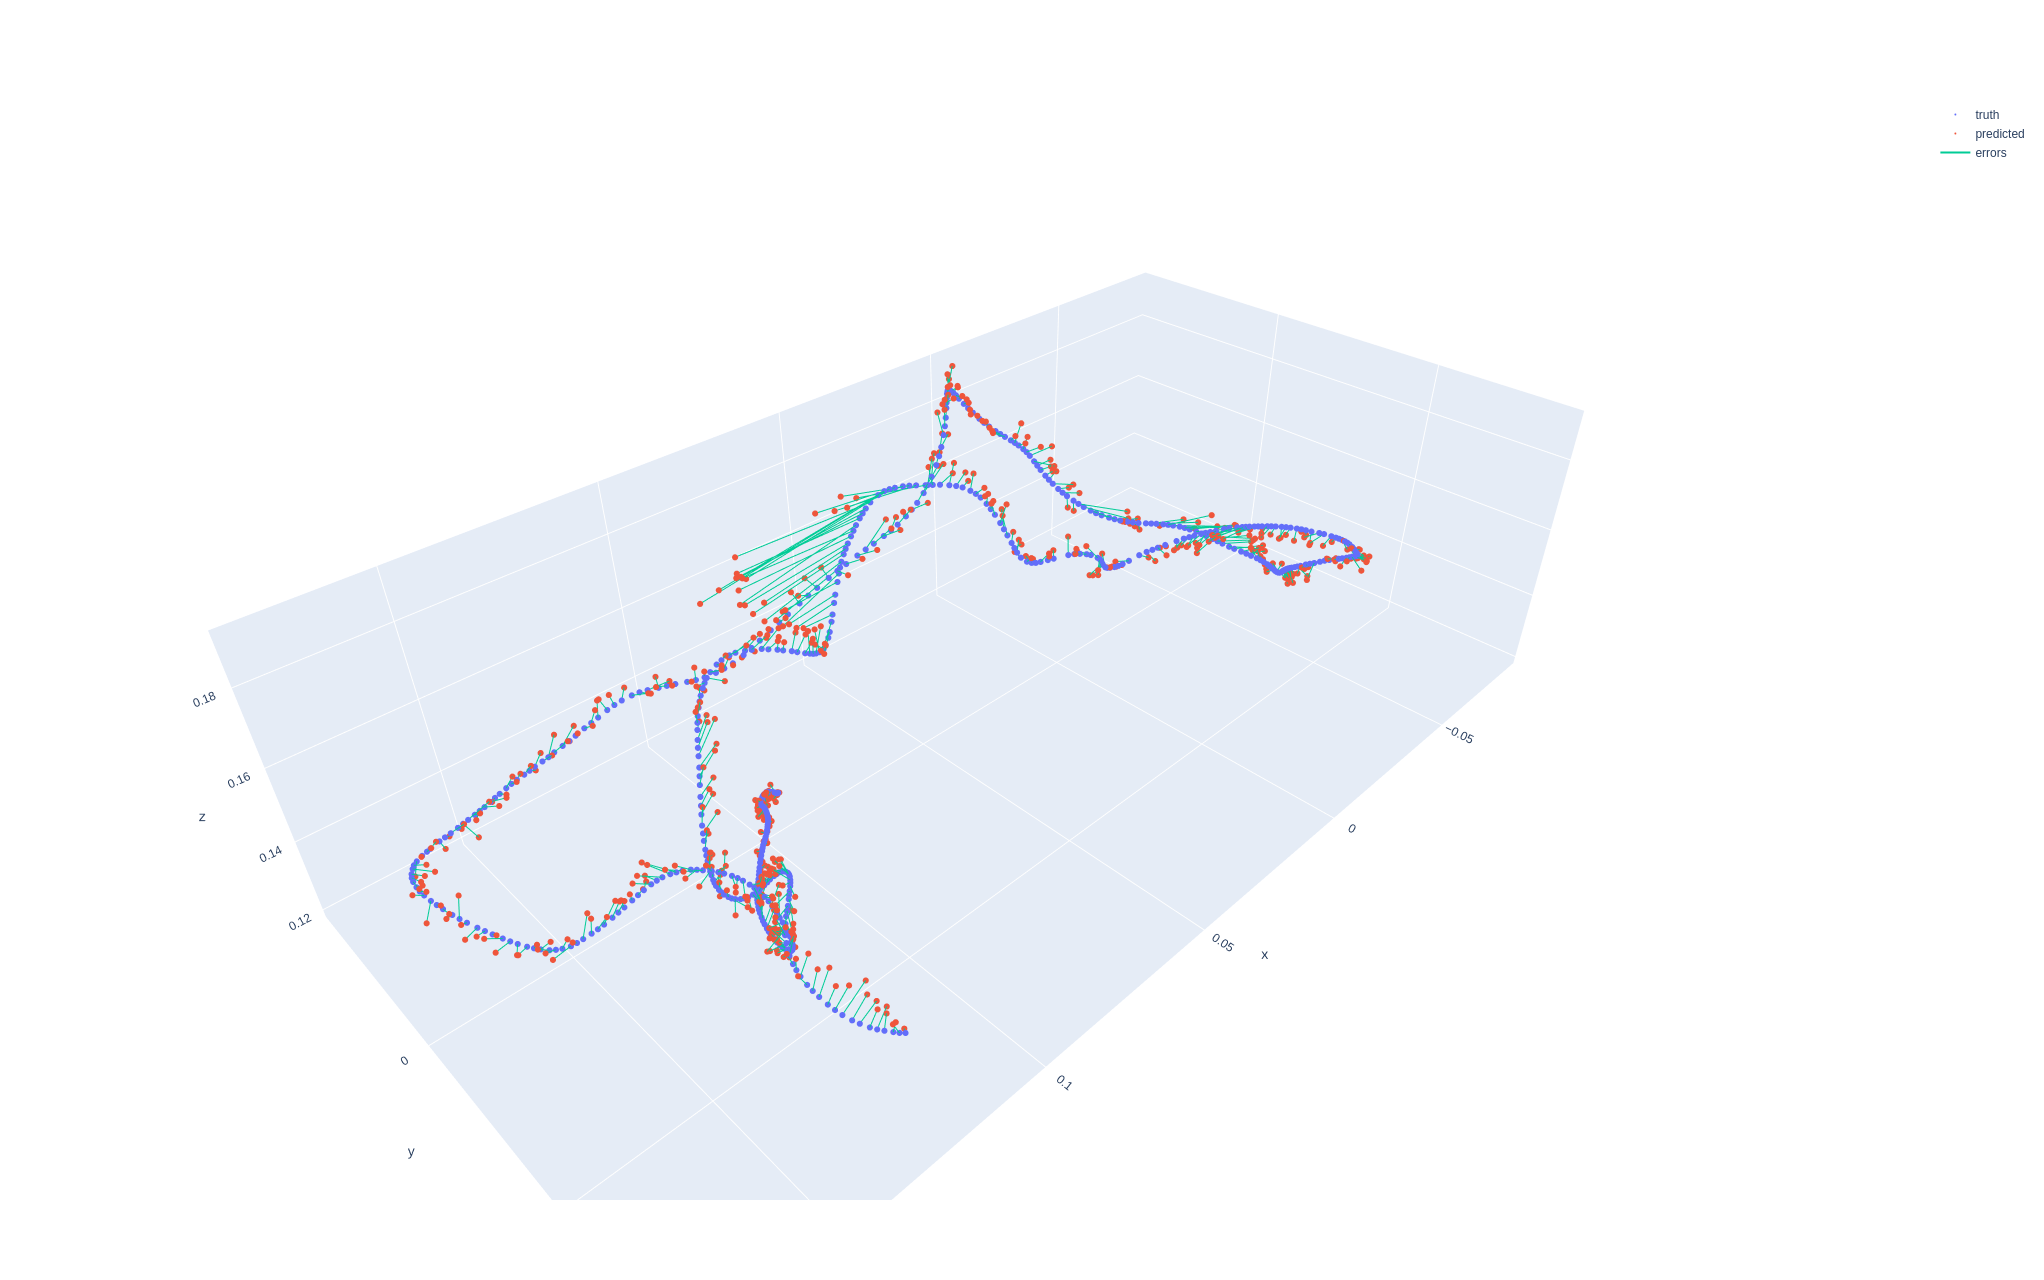

In [29]:
show_trajectories(np.array(gt_poses)[:, 3, :3], np.array(poses)[:, 3, :3])

In [72]:
poses[0]

array([[ 0.8735127 ,  0.48643783,  0.01880984,  0.        ],
       [ 0.34341863, -0.58838165, -0.73203176,  0.        ],
       [-0.3450206 ,  0.64589864, -0.6810106 ,  0.        ],
       [ 0.13191056,  0.08617777,  0.15277901,  1.        ]],
      dtype=float32)

In [73]:
gt_poses[0]

array([[ 0.8722986 ,  0.4882979 ,  0.02569568,  0.        ],
       [ 0.34789497, -0.58283824, -0.73434913,  0.        ],
       [-0.34360474,  0.64951116, -0.67828536,  0.        ],
       [ 1.3112    ,  0.8507    ,  1.5186    ,  1.        ]],
      dtype=float32)